## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


##### User-user и item-item схожи тем, что ищут похожести (similarity) по своим соседям. Так же оба определяют средний score по соседям для рекомендации. Оба стоятся на основе User-item матрицы. Item-item алгоритм сложенее, т.к. в матрице возможно большое количество item_id. 
##### Если имеем функцию item_item_rec, то можем использовать ее для user_user_rec. Для этого необходимо транспонировать матрицу.
##### item-item - kNN, а ALS - градиентный спуск. item-item в основе использует формулу схожести (similarity), а ALS использует функцию потерь, в которой есть веса ошибок, а так же коэффициент регуляризации. То есть имеет больше гиперпараметров, которые мы можем подбирать для улучшения качаества предсказаний.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


##### Рейтинг (оценка пользователями) товаров. Категории товаров. Частота покупок товара (возможно, товары первой необходимости могут иметь большую важность.)

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


##### Здесь не знаю ответа. и где почитать об этом тоже не нашел. Буду благодарен, если в ответе сможете приложить ссылку где об этом почитать, спасибо.

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

##### Этого пока не было на семинаре. ответ на этот вопрос к дз4.

## Практическая часть


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
    
#from src.metrics import precision_at_k 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/Users/andrewvolkov/Documents/Study/RecSys/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('/Users/andrewvolkov/Documents/Study/RecSys/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [54]:
values1 = ['quantity', 'count']

In [9]:
# Заведем фиктивный item_id (если юзер не покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_item_matrix.shape

(2499, 5001)

In [11]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [12]:
# ?AlternatingLeastSquares

In [13]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 16.9 s, sys: 364 ms, total: 17.2 s
Wall time: 12.4 s


In [14]:
[id_to_itemid[rec[0]] for rec in recs]

[1106523, 1133018, 999999, 1082185, 5569230]

In [15]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [16]:
result

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


In [17]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [18]:
%%time
    
result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 21s, sys: 3.23 s, total: 1min 24s
Wall time: 47.2 s


0.7338135254101504

In [19]:
ct1 = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [20]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 14s, sys: 2.97 s, total: 1min 17s
Wall time: 43.2 s


0.16052889324191755

In [21]:
c1 = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [22]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1100972, 901062, 1033142, 979707, 5569374]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 951590, 965766, 938700]"


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [23]:
# ?pd.pivot_table

In [57]:
values2 = ['sales_value', 'sum']

In [24]:
user_item_matrix_2 = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc=np.sum, 
                                  fill_value=0
                                 )

user_item_matrix_2 = user_item_matrix_2.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix_2).tocsr()

user_item_matrix_2.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
def ui_to_ids(matrix):
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    
    return itemid_to_id, userid_to_id

In [26]:
itemid_to_id, userid_to_id = ui_to_ids(user_item_matrix_2)

In [27]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_2).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_2).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 17 s, sys: 308 ms, total: 17.3 s
Wall time: 11.8 s


In [28]:
%%time
    
result_train['als_2'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als_2'], row['actual']), axis=1).mean()

CPU times: user 1min 21s, sys: 3.39 s, total: 1min 25s
Wall time: 46.4 s


0.5926370548219229

In [29]:
ct2 = result_train.apply(lambda row: precision_at_k(row['als_2'], row['actual']), axis=1).mean()

In [30]:
%%time
    
result['als_2'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_2'], row['actual']), axis=1).mean()

CPU times: user 1min 11s, sys: 2.81 s, total: 1min 14s
Wall time: 40.8 s


0.10039177277179172

In [50]:
c2 = result.apply(lambda row: precision_at_k(row['als_2'], row['actual']), axis=1).mean()

In [32]:
result.head(2)

,user_id,actual,als,als_2
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1100972, 901062, 1033142, 979707, 5569374]","[965766, 5569374, 979707, 1105488, 1051211]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 951590, 965766, 938700]","[940947, 827180, 1106301, 925626, 845078]"


In [61]:
values3 = ['sales_value', 'mean']

In [33]:
user_item_matrix_3 = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc=np.mean, 
                                  fill_value=0
                                 )

user_item_matrix_3 = user_item_matrix_3.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix_3).tocsr()

user_item_matrix_3.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
itemid_to_id, userid_to_id = ui_to_ids(user_item_matrix_3)

In [35]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_3).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_3).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 16.3 s, sys: 286 ms, total: 16.6 s
Wall time: 11.2 s


In [36]:
%%time
    
result_train['als_3'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als_3'], row['actual']), axis=1).mean()

CPU times: user 1min 22s, sys: 3.6 s, total: 1min 26s
Wall time: 49 s


0.7430972388955386

In [37]:
ct3 = result_train.apply(lambda row: precision_at_k(row['als_3'], row['actual']), axis=1).mean()

In [38]:
%%time
    
result['als_3'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_3'], row['actual']), axis=1).mean()

CPU times: user 1min 13s, sys: 2.97 s, total: 1min 16s
Wall time: 42.3 s


0.13290891283055678

In [51]:
c3 = result.apply(lambda row: precision_at_k(row['als_3'], row['actual']), axis=1).mean()

In [40]:
result.head(2)

,user_id,actual,als,als_2,als_3
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1100972, 901062, 1033142, 979707, 5569374]","[965766, 5569374, 979707, 1105488, 1051211]","[1005186, 1021164, 1100972, 5569374, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 951590, 965766, 938700]","[940947, 827180, 1106301, 925626, 845078]","[910032, 1022003, 1044078, 1133018, 914190]"


In [59]:
values4 = ['retail_disc', 'mean']

In [41]:
user_item_matrix_4 = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='retail_disc', # Можно пробовать другие варианты
                                  aggfunc=np.mean, 
                                  fill_value=0
                                 )

user_item_matrix_4 = user_item_matrix_4.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix_4).tocsr()

user_item_matrix_4.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
itemid_to_id, userid_to_id = ui_to_ids(user_item_matrix_4)

In [43]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_4).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix_4).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 12.5 s, sys: 278 ms, total: 12.8 s
Wall time: 8.09 s


In [44]:
%%time
    
result_train['als_4'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result_train.apply(lambda row: precision_at_k(row['als_4'], row['actual']), axis=1).mean()

CPU times: user 50.5 s, sys: 2.83 s, total: 53.3 s
Wall time: 31.2 s


0.06154461784713888

In [45]:
ct4 = result_train.apply(lambda row: precision_at_k(row['als_4'], row['actual']), axis=1).mean()

In [46]:
%%time
    
result['als_4'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als_4'], row['actual']), axis=1).mean()

CPU times: user 45.3 s, sys: 2.31 s, total: 47.6 s
Wall time: 26.2 s


0.00695396669931439

In [52]:
c4 = result.apply(lambda row: precision_at_k(row['als_4'], row['actual']), axis=1).mean()

In [48]:
result.head(2)

,user_id,actual,als,als_2,als_3,als_4
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1100972, 901062, 1033142, 979707, 5569374]","[965766, 5569374, 979707, 1105488, 1051211]","[1005186, 1021164, 1100972, 5569374, 1082185]","[941183, 941361, 941797, 941741, 16809471]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 951590, 965766, 938700]","[940947, 827180, 1106301, 925626, 845078]","[910032, 1022003, 1044078, 1133018, 914190]","[941183, 941361, 941797, 941741, 16809471]"


In [62]:
c_data = {'C_matrix_number': [1, 2, 3, 4],
          'value': [values1[0], values2[0], values3[0], values4[0]],
          'aggfunc': [values1[1], values2[1], values3[1], values4[1]],
         'Train_result': [ct1, ct2, ct3, ct4],
         'Test_result': [c1, c2, c3, c4]}

c_data = pd.DataFrame(c_data)
c_data

,C_matrix_number,value,aggfunc,Train_result,Test_result
0,1,quantity,count,0.733814,0.160529
1,2,sales_value,sum,0.592637,0.100392
2,3,sales_value,mean,0.743097,0.132909
3,4,retail_disc,mean,0.061545,0.006954


#####  Использование sales_value mean показывает лучший результат на трейне. однако quantity count дает лучший результат на тесте

##### Для следующего задания буду использовать матрицу1

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [118]:
factors = [75, 100, 125]
regularizations = [0.01, 0.001, 0.0001]
iters = [5, 15, 30]

In [119]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
itemid_to_id, userid_to_id = ui_to_ids(user_item_matrix)

In [121]:
search_params = pd.DataFrame(columns=['Iterations', 'Regularization', 'Factors', 'time', 'score_train', 'score_test'])
search_params

,Iterations,Regularization,Factors,time,score_train,score_test


In [122]:
%%time


for i in iters:
    for reg in regularizations:
        for factor in factors:
            start_time = time.time()
            column = f'Iters: {i}, Reg: {reg}, Factors{factor}'
            model = AlternatingLeastSquares(factors=factor, #k
                                            regularization=reg,
                                            iterations=i, 
                                            calculate_training_loss=True, 
                                            num_threads=4)

            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
                      show_progress=False)

            recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                                    user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                                    N=5, # кол-во рекомендаций 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)
            
            result_train[column] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            res_train = result_train.apply(lambda row: precision_at_k(row[column], row['actual']), axis=1).mean()
            
            result[column] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            res_test = result.apply(lambda row: precision_at_k(row[column], row['actual']), axis=1).mean()
            
            cicle_time = time.time() - start_time
            
            res = [i, reg, factor, cicle_time, res_train, res_test]
            res_series = pd.Series(res, index = search_params.columns)
            search_params = search_params.append(res_series, ignore_index=True)

CPU times: user 1h 17min 9s, sys: 2min 42s, total: 1h 19min 51s
Wall time: 46min 2s


In [251]:
result.head(1)

,user_id,actual,als,als_2,als_3,als_4,"Iters: 20, Reg: 0.01, Factors100","Iters: 20, Reg: 0.01, Factors150","Iters: 20, Reg: 0.01, Factors300","Iters: 20, Reg: 0.001, Factors100",...,"Iters: 15, Reg: 0.0001, Factors125","Iters: 30, Reg: 0.01, Factors75","Iters: 30, Reg: 0.01, Factors100","Iters: 30, Reg: 0.01, Factors125","Iters: 30, Reg: 0.001, Factors75","Iters: 30, Reg: 0.001, Factors100","Iters: 30, Reg: 0.001, Factors125","Iters: 30, Reg: 0.0001, Factors75","Iters: 30, Reg: 0.0001, Factors100","Iters: 30, Reg: 0.0001, Factors125"
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1100972, 901062, 1033142, 979707, 5569374]","[965766, 5569374, 979707, 1105488, 1051211]","[1005186, 1021164, 1100972, 5569374, 1082185]","[941183, 941361, 941797, 941741, 16809471]","[941183, 941361, 941797, 941741, 16809471]","[941183, 941361, 941797, 941741, 16809471]","[941183, 941361, 941797, 941741, 16809471]","[941183, 941361, 941797, 941741, 16809471]",...,"[1033142, 979707, 995242, 5569374, 9527290]","[878996, 1033142, 1005186, 1100972, 901062]","[1033142, 5569374, 1005186, 995242, 979707]","[1033142, 965766, 5569374, 979707, 995242]","[901062, 1033142, 5569374, 1100972, 832678]","[1033142, 5569374, 1005186, 995242, 979707]","[1033142, 5569374, 979707, 904360, 995242]","[1005186, 5569374, 1100972, 1033142, 1105488]","[1033142, 979707, 995242, 1105488, 1005186]","[5569374, 1033142, 1051211, 979707, 995242]"


In [255]:
search_params.sort_values('score_test', ascending=False).head()

,Iterations,Regularization,Factors,time,score_train,score_test
2,5.0,0.0100,125.0,115.435416,0.727891,0.173947
1,5.0,0.0100,100.0,92.326720,0.695718,0.171009
0,5.0,0.0100,75.0,68.425713,0.658023,0.169344
6,5.0,0.0001,75.0,69.504136,0.662905,0.169050
7,5.0,0.0001,100.0,86.270365,0.701240,0.168756


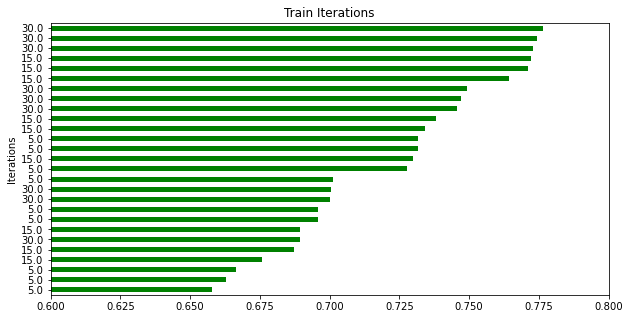

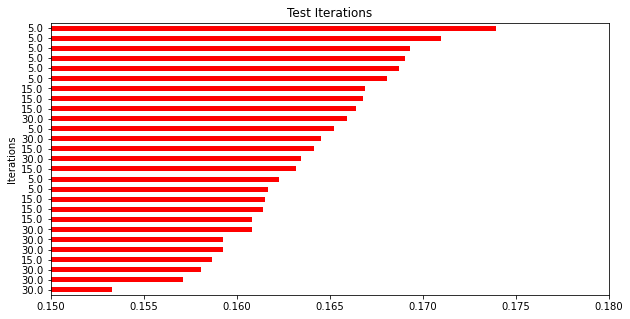

In [263]:
search_params.sort_values('score_train').plot(kind='barh',
                                              x='Iterations',
                                              y='score_train',
                                              color='green',
                                              legend=False,
                                              title='Train Iterations',
                                              figsize=(10, 5),
                                              xlim=(0.6, 0.8))
search_params.sort_values('score_test').plot(kind='barh',
                                             x='Iterations',
                                             y='score_test',
                                             color='red',
                                             legend=False,
                                             title='Test Iterations',
                                             figsize=(10, 5),
                                             xlim=(0.15, 0.18))

##### На трейне модель показывает лучший результат при большем количестве итераций. Однако, на тесте результат увеличивается при уменьшении количества итераций.

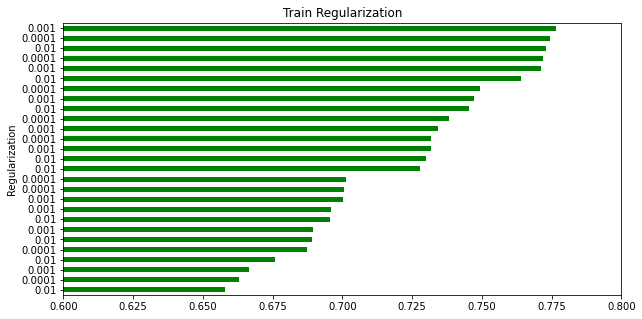

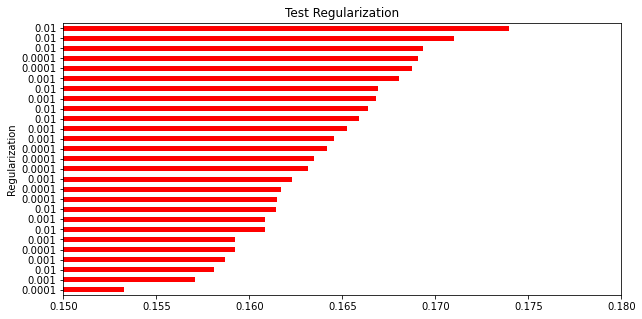

In [264]:
search_params.sort_values('score_train').plot(kind='barh',
                                              x='Regularization',
                                              y='score_train',
                                              color='green',
                                              legend=False,
                                              title='Train Regularization',
                                              figsize=(10, 5),
                                              xlim=(0.6, 0.8))
search_params.sort_values('score_test').plot(kind='barh',
                                             x='Regularization',
                                             y='score_test',
                                             color='red',
                                             legend=False,
                                             title='Test Regularization',
                                             figsize=(10, 5),
                                             xlim=(0.15, 0.18))

##### Лучшие 3 результата на тесте дает регуляризация 0.01. Однако на трейне не прослеживается зависимости между регуляризацией и результатом

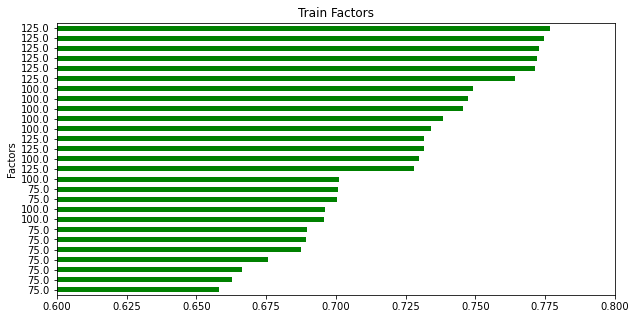

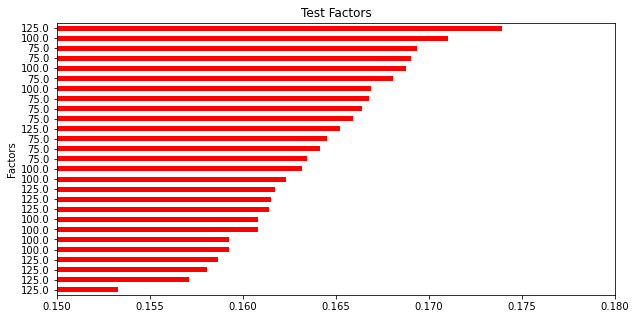

In [271]:
search_params.sort_values('score_train').plot(kind='barh',
                                              x='Factors',
                                              y='score_train',
                                              color='green',
                                              legend=False,
                                              title='Train Factors',
                                              figsize=(10, 5),
                                              xlim=(0.6, 0.8))
search_params.sort_values('score_test').plot(kind='barh',
                                             x='Factors',
                                             y='score_test',
                                             color='red',
                                             legend=False,
                                             title='Test Factors',
                                             figsize=(10, 5),
                                             xlim=(0.15, 0.18))

##### Как видно, на трейне качество возрастает практически постоянно при увеличении количества факторов. Однако на тесте вверху графика наблюдаются разные значения количества факторов. Следовательно количество факторов само по себе на тесте не дает лучших результатов, только в савокупности с другими параметрами

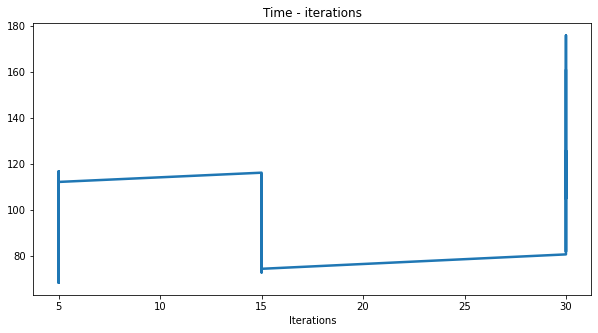

In [248]:
search_params.sort_values('Iterations').plot(kind='line',
                                             x='Iterations',
                                             y='time',
                                             legend=False,
                                             title='Time - iterations',
                                             figsize=(10, 5),
                                             linewidth=2.5)

In [240]:
# результат учебного алгоритма был 0.73
search_params['score_train'].max()

0.7765506202480841

In [241]:
# результат учебного алгоритма был 0.164
search_params['score_test'].max()

0.17394711067580568

In [246]:
# лучшие параметры из использованных
search_params.iloc[search_params['score_test'].argmax()]

Iterations          5.000000
Regularization      0.010000
Factors           125.000000
time              115.435416
score_train         0.727891
score_test          0.173947
Name: 2, dtype: float64

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!